## Utilizing Non Constant Learning Rates

In [7]:
import numpy as np
from IntelliLab.models.Layer import Layer
from IntelliLab.models.Sequential import Sequential

#### Create Artificial Data

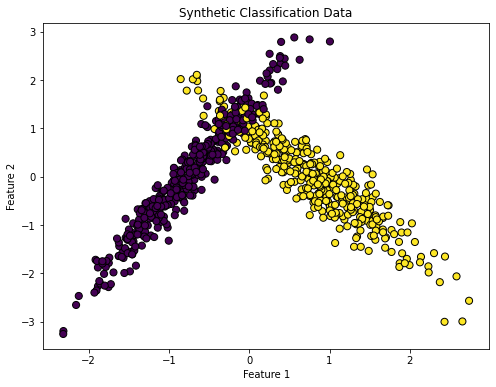

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to create and plot synthetic classification data
def create_classification_data():
    # Generate synthetic data
    X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                               n_clusters_per_class=1, flip_y=0, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=50)
    plt.title('Synthetic Classification Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

    return X_train, X_test, y_train, y_test

# Create synthetic classification data
X_train, X_test, y_train, y_test = create_classification_data()

#### Create a library with several learning functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class FloatingRate:
    def __init__(self, function_name, function_params):
        self.function_name = function_name
        self.function_params = function_params

    def __call__(self, epoch):
        # Call the appropriate function based on the function_name
        if self.function_name == 'decaying_sine':
            return self.decaying_sine(epoch)
        elif self.function_name == 'sine':
            return self.sine(epoch)
        elif self.function_name == 'exponential':
            return self.exponential(epoch)
        elif self.function_name == 'linear':
            return self.linear(epoch)
        elif self.function_name == 'polynomial_decay':
            return self.polynomial_decay(epoch)
        else:
            raise ValueError(f"Unsupported function: {self.function_name}")

    def decaying_sine(self, x):
        amplitude, offset, frequency, decay_rate = self.function_params.values()
        decay_term = np.exp(-decay_rate * x)
        return amplitude * np.sin(2 * np.pi * frequency * x) * decay_term + offset

    def sine(self, x):
        amplitude, frequency = self.function_params.values()
        return amplitude * np.sin(2 * np.pi * frequency * x)

    def exponential(self, x):
        decay_rate = self.function_params['decay_rate']
        return np.exp(-decay_rate * x)

    def linear(self, x):
        slope, intercept = self.function_params.values()
        return slope * x + intercept

    def polynomial_decay(self, x):
        a, b, c, d, e, f, decay_rate = self.function_params.values()
        # 5th-degree polynomial decay function: f(x) = a * x^5 + b * x^4 + c * x^3 + d * x^2 + e * x + f, scaled by exponential decay
        polynomial_term = a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f
        decay_term = np.exp(-decay_rate * x)
        return np.maximum(0, polynomial_term * decay_term)

    def plot(self):
        # Generate x values from 0 to 10
        x_values = np.linspace(0, 10, 1000)

        # Calculate corresponding y values using the custom function
        y_values = self(x_values)

        # Plot the function
        plt.plot(x_values, y_values, label=f'Function: {self.function_name}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('Custom Function')
        plt.legend()
        plt.grid(True)
        plt.show()

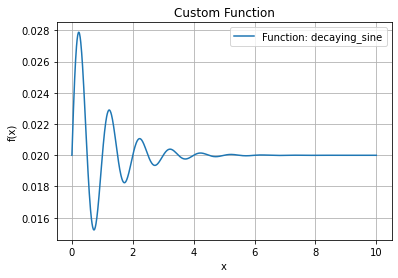

In [5]:
floating_rate_instance = FloatingRate(function_name='decaying_sine', function_params={
    "amplitude": 0.01,
    "offset": 0.02,
    "frequency": 1,
    "decay_rate": 1
})
floating_rate_instance.plot()

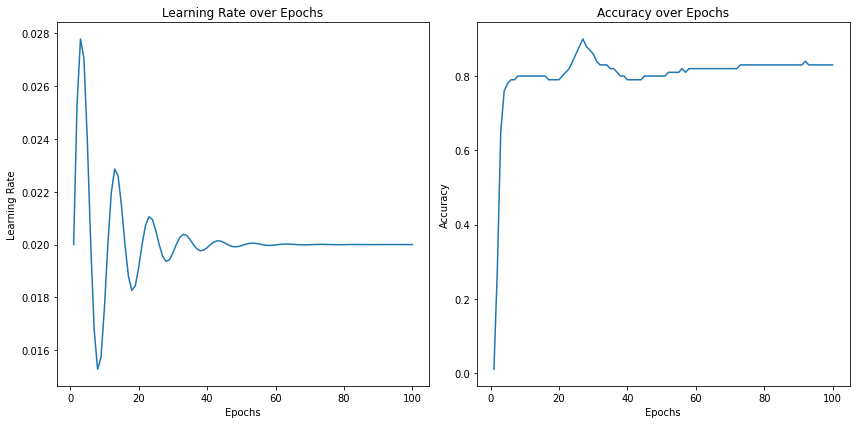

In [14]:
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
import os

# Create a DataFrame to store parameters, accuracy, and loss
columns = ["amplitude", "offset", "frequency", "decay_rate", "accuracy"]
params_df = pd.DataFrame(columns=columns)

# Measurement folder name
f_name = "amplitude_variations"

# Define the parameter values
amplitudes = np.linspace(0.001, 0.01, 10)
offsets = np.linspace(0.02, 0.01, 1)
frequencies = np.linspace(1, 100, 1)
decay_rates = np.linspace(0.1, 1, 10)

# Training loop with parameter changes
for amplitude in amplitudes:
    for offset in offsets:
        for frequency in frequencies:
            for decay_rate in decay_rates:
                # Print actual settings
                print(f"Amplitude: {amplitude}, Offset: {offset}, Frequency: {frequency}, Decay Rate: {decay_rate}")
                
                # Create the neural network model
                nn = Sequential([
                    Layer(m_inputs=2, n_perceptrons=2, activation="relu"),
                    Layer(m_inputs=2, n_perceptrons=6, activation="relu"),
                    Layer(m_inputs=6, n_perceptrons=1, activation="sigmoid"),
                ], cost="cce", tolerance=0.15)

                learn_function = FloatingRate(function_name="decaying_sine", function_params={
                    "amplitude": amplitude,
                    "offset": offset,
                    "frequency": frequency,
                    "decay_rate": decay_rate
                })

                # Train the neural network
                nn.fit(X_train=X_train, y_train=y_train, epochs=100, learn_rate=0.001, learn_function=learn_function, functional_interval=10)
                
                # Save the parameters, accuracy, and loss in the DataFrame
                params_df = pd.concat([params_df, pd.DataFrame({
                    "amplitude": amplitude,
                    "offset": offset,
                    "frequency": frequency,
                    "decay_rate": decay_rate,
                    "accuracy": nn.epochs_accuracies[-1]
                }, index=[0])], ignore_index=True)

                # Clear Output
                clear_output()

                # Folder check
                if not os.path.exists(f"./data/{f_name}"):
                    os.makedirs(f"./data/{f_name}")

                # Plot the function and accuracy in one plot
                plt.figure(figsize=(12, 6))

                # Plot the learning rate
                plt.subplot(1, 2, 1)
                sns.lineplot(x=range(1, len(nn.epochs_learn_rates) + 1), y=nn.epochs_learn_rates)
                plt.title('Learning Rate over Epochs')
                plt.xlabel('Epochs')
                plt.ylabel('Learning Rate')

                # Plot the accuracy
                plt.subplot(1, 2, 2)
                sns.lineplot(x=range(1, len(nn.epochs_accuracies) + 1), y=nn.epochs_accuracies)
                plt.title('Accuracy over Epochs')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')

                plt.tight_layout()
                plt.savefig(f'./data/{f_name}/combined_plot_amplitude_{np.round(amplitude,2)}_offset_{np.round(offset,2)}_frequency_{np.round(frequency,2)}_decay_rate_{np.round(decay_rate,2)}.png')
                plt.show()

# Save the DataFrame to a CSV file
params_df.to_csv('parameter_results.csv', index=False)